# 1. INIT - Imports

In [1]:
import os
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pympler import asizeof
from visdom import Visdom
from copy import deepcopy
import time
import networkx as nx
import logging
from sklearn.manifold import TSNE
import umap.umap_ as umap
from cmcrameri import cm
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
#this is set for the printing of Q-matrices via console
torch.set_printoptions(precision=3, sci_mode=False, linewidth=100)

from tqdm.auto import tqdm, trange

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#Uncomment if GPU is to be used - right now use CPU, as we have very small networks and for them, CPU is actually faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#suppress scientific notation in printouts
np.set_printoptions(suppress=True)

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])
 
    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)
 
    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)
 
    return logger

def log_print(message, logger=None):
    if logger:
        logger.info(message)
    else:
        print(message)

# 2. INIT - Parameters

In [4]:
init_color_hex: str = "#2f78b6" # hex color of init point (left top)
goal_color_hex: str = '#f0b226' # hex color of goal point (right bottom)
wall_color: list[float] = [0.7, 0.7, 0.7] # RGB color of walls

n_cell: int = 4 # how many original cells
grid_dim = n_cell * 2 - 1 # side length of the square gridworld, in the form of 2n-1
n_actions: int = 4 # how many actions are possible in each state
lava: bool = False #do we use lava states - i.e. accessible wall states - (True) or wall states (False)? (we now always use "False")
starting_state: int = 0
goal_state = grid_dim ** 2 - 1

# generation of maze
maze_gen: bool = False # generate wall_states? wall_state_dict {0: [], 1: [1], 2: [2], 3: [3], ... } consists of 
n_mazes: int = 3800

# rewards in the gridworld (-0.1, 100, -5)
step_reward: float = -0.1 # for taking a step
goal_reward: float = 2. # for reaching the goal
wall_reward: float = -1. # for bumping into a wall

# Net settings
input_neurons: int = 2 # for network init
output_neurons = n_actions # modeling the Q(s, a) value by the output neurons w.r.t. number of action
using_mazearray_as_concept: bool = False
using_mazearray_as_concept_str = "_fixedconcept" if using_mazearray_as_concept else ""
supervised_mazearray_as_concept: bool = False
supervised_mazearray_as_concept_str = "_supervisedconcept" if supervised_mazearray_as_concept else ""
concept_size: int = 64 if (using_mazearray_as_concept is False and supervised_mazearray_as_concept is False) else grid_dim * grid_dim # the concept vector size of CA-TS DQN
supervised_1st_common_concept: bool = True
supervised_1st_common_concept_str = "_supervised1stcommon" if supervised_1st_common_concept else ""
using_concept_eps: bool = True
concept_eps: float = 1.0
concept_eps_str = f"_cpteps{concept_eps}" if using_concept_eps else ""
using_res: bool = True
res_str = "_res" if using_res else ""
hidden_dims: list = [768] * 18
dim_str = "-".join(str(d) for d in hidden_dims)
q_s2a: bool = False # whether using Q(s) -> a: True or Q(s, a): False
q_str = "" if q_s2a else "_sa2q"
n_agents: int = 5 # how many anegts used in communication games
i_agent: int = 1 # agent index == 0, i.e. no group
n_unique: int = 20 # unique mazes learned by each agent
n_group: int = 11
group_str = f"group{n_group}/" if i_agent != 0 else ""

# training settings
train_dqn: bool = False
batch_size: int = 512 # 0 indicates using all data in buffer as a batch
epsilon: float = 0.1 # greedy action policy
lr: float = 1e-4 # learning rate
gamma_bellman: float = 0.9999 # bellman equation
target_replace_steps: int = 0 # renew target_net by eval_net after how many iter times, 0 indicates directly using eval_net as target_net
memory_capacity: int = 0 # number transitions stored, 0 indicates pre-store all transitions in memory (change training mode as epoch manner)
cap_str = "" if memory_capacity != 0 else "_prestore"
upper_steps: int = 100 # truncated steps
n_episode: int = 100000
all_action_one_state: bool = True
ckpt_file: str = f"agent_ckpt/{group_str}ckpt{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.pt"
memory_file: str = f"agent_memory/{group_str}memory{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.npy"
log_file: str = f"agent_log/{group_str}log{i_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.log"


# communication testing
load_ckpt: bool = True
load_concepts_from_others: bool = True
rand_unknown_concepts: bool = False
ep_r_idx_str: str = "after" if load_concepts_from_others else "before"
test_only_unique: bool = True
unique_str: str = "unique" if test_only_unique else "all"
save_ep_r: bool = False
comm_trail_num: int = 10
ep_r_file: str = f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_{ep_r_idx_str}_test_{unique_str}_trail{comm_trail_num}.pt"

# CA-TS generalization ability test
test_concept_generalization: bool = False
learn_old_mazes: bool = False
n_generalization_mazes: int = 5
memory_test_capacity: int = 0
n_test_episode: int = 10
lr_test: float = 1e-3
test_rand_start: bool = False

# 3. FUNCTIONS - Log

In [6]:
if train_dqn:
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    logger = get_logger(log_file)
else:
    logger = None

In [10]:
for i in trange(10, desc="Playing Mazes"):
    print(i)

Playing Mazes:   0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9


# 4. FUNCTIONS - Gridworld class and state representation transformations

In [7]:
class SquareGridworld():
    """
    the class for the gridworlds

    n**2 states (n-by-n gridworld) -> n is the grid dimension

    The mapping from state to the grid is as follows:
    n(n-1)  n(n-1)+1  ...  n^2-1
    ...     ...       ...  ...
    n       n+1       ...  2n-1
    0       1         ...  n-1

    Actions 0, 1, 2, 3 correspond to right, up, left, down (always exactly one step)

    -Landing in the goal_state gets a reward of goal_reward and ends the episode
    -Bumping into wall states or the map border incurs a reward of wall_reward
    -In case of lava=False, the agent bounces back from walls, while in case of lava=True wall states are accessible (the outside boundary can never be crossed)
    -Each step additionally incurs a reward of step_reward
    """
    def __init__(self, goal_state: int, wall_states: 'list[int]', lava: bool = False):

        self.goal_state: int=goal_state
        self.wall_states: 'list[int]'=wall_states
        self.n_states: int = grid_dim**2
        self.lava: bool = lava


    def get_outcome(self, state: int, action: int)-> 'tuple[Optional[int], float]':
        '''
        given a state and an action, this returns the next state and the immediate reward for the action
        ---
        INPUT
        state: the state the agent is in, can not equal to the goal_state
        action: the action taken
        ---
        OUTPUT
        next_state - the next state
        reward - the reward for the action taken
        '''

        #get the next state before taking into account walls or outside boundary
        next_state_dict={0:state+1, 1:state+grid_dim, 2:state-1, 3:state-grid_dim}
        #for all actions, this dictionary stores a boolean indicating whether we cross the map border executing this action in our current state
        cross_boundary_dict={0:state % grid_dim == grid_dim-1, 1:state >= grid_dim*(grid_dim-1), 2:state % grid_dim ==0, 3:state<grid_dim}

        #case that we have lava states that the agent can walk through with large negative reward
        if self.lava:
            reward=step_reward
            next_state=next_state_dict[action]
            #bounce back from map border
            if cross_boundary_dict[action]:
                reward+=wall_reward
                next_state=state
            #entering or exiting a lava state gives negative reward, but we do not bounce back
            elif next_state in self.wall_states or state in self.wall_states:
                reward+=wall_reward

        #case that we have wall states that the agent bounces back from
        else:
            reward=step_reward
            next_state=next_state_dict[action]
            #bounce back from a wall or the map border?
            if next_state in self.wall_states or cross_boundary_dict[action]:
                next_state=state #bounce back
                reward+=wall_reward
            
            if next_state == self.goal_state:
                reward=goal_reward


        return int(next_state), reward


    def get_outcomes(self) -> 'dict[ tuple[int,float] , tuple[Optional[int], float] ]':
        '''
        returns a dictionary where for every possible combination of state and action we get the next state and
        corresponding immediate reward
        ---
        OUTPUT
        outcomes - the dictionary keyed by state-action combo, whose values are the next states and rewards
        '''
        outcomes = {(s, a): self.get_outcome(s,a) for s in range(self.n_states) for a in range(n_actions)}
        return outcomes



def state_int_to_tuple(state_int: Optional[int]) -> Optional[torch.tensor]:
    '''
    Gets state tuple representation (coordinates) from integer representation
    ---
    INPUT
    state_int - the state integer representation
    ---
    OUTPUT
    state - the state tuple representation
    '''
    if state_int==None:
        return None
    else:
        cval: float=(grid_dim-1)/2 #center (0,0) is in the middle of the grid
        sx,sy=state_int%grid_dim-cval, mt.floor(state_int/grid_dim)-cval
        state = torch.tensor([[sx,sy]],device=device)
        return state

def batch_state_int_to_tuple(batch_state_int: list[int]) -> Optional[torch.tensor]:
    '''
    Gets batch state tuple representation (coordinates) from integer representation
    ---
    INPUT
    state_int - the state integer representation
    ---
    OUTPUT
    state - the state tuple representation
    '''
    state_tensor_list = []
    for state_int in batch_state_int:
        state_tensor = state_int_to_tuple(state_int)
        state_tensor_list.append(state_tensor)
    return torch.cat(state_tensor_list, dim = 0)

def state_tuple_to_int(state: Optional[torch.tensor]) -> Optional[int]:
    '''
    Gets state integer representation from tuple representation (coordinates)
    ---
    INPUT
    state - the state tuple representation
    ---
    OUTPUT
    state_int - the state integer representation
    '''
    if state==None:
        return None
    else:
        cval: float = (grid_dim-1)/2
        sx = state[:, 0] + cval
        sy = state[:, 1] + cval
        state_int = sx + grid_dim * sy
        return state_int.tolist()


# 5. FUNCTIONS - Graph options

In [101]:
def graph_from_walls(grid_dim, wall_states):
    '''
    Creates a graph representing the gridworld without walls.
    
    Parameters:
    grid_dim (int): The dimension of the grid.
    wall_states (list of int): Positions that are walls.
    
    Returns:
    G (nx.Graph): Graph representing the gridworld.
    '''
    G = nx.Graph()
    
    # Add nodes for passable cells
    for s in range(grid_dim**2):
        if s not in wall_states:
            x = s % grid_dim
            y = mt.floor(s / grid_dim)
            G.add_node(s, pos=(x, y))
    
    # Add edges between adjacent passable cells
    for s1 in range(grid_dim**2):
        if s1 in G.nodes:
            # Check right neighbor
            s2 = s1 + 1
            if s2 in G.nodes and (s1 % grid_dim) != grid_dim - 1:
                G.add_edge(s1, s2, weight=1)
            # Check up neighbor
            s2 = s1 + grid_dim
            if s2 in G.nodes and (s1 // grid_dim) != grid_dim - 1:
                G.add_edge(s1, s2, weight=1)
    
    return G

def shortest_path(grid_dim, wall_states, start, goal):
    '''
    Finds the shortest path between two points in the gridworld.
    
    Parameters:
    grid_dim (int): The dimension of the grid.
    wall_states (list of int): Positions that are walls.
    start (int): Start position.
    goal (int): Goal position.
    
    Returns:
    list: The shortest path from start to goal, or an empty list if no path exists.
    '''
    G = graph_from_walls(grid_dim, wall_states)
    
    if start not in G.nodes or goal not in G.nodes:
        return []
    
    try:
        path = nx.shortest_path(G, source=start, target=goal, weight='weight')
    except nx.NetworkXNoPath:
        path = []
    
    return path

# 6. FUNCTIONS - Wall states array

In [102]:
class Cell:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.visited = False
        self.neighbours = []

    def add_neighbour(self, neighbour):
        self.neighbours.append(neighbour)

class Grid:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.cells = [[Cell(x, y) for y in range(height)] for x in range(width)]
        self._link_neighbours()

    def _link_neighbours(self):
        for x in range(self.width):
            for y in range(self.height):
                cell = self.cells[x][y]
                if x > 0:
                    cell.add_neighbour(self.cells[x - 1][y])
                if x < self.width - 1:
                    cell.add_neighbour(self.cells[x + 1][y])
                if y > 0:
                    cell.add_neighbour(self.cells[x][y - 1])
                if y < self.height - 1:
                    cell.add_neighbour(self.cells[x][y + 1])

    def random_cell(self):
        x = random.randint(0, self.width - 1)
        y = random.randint(0, self.height - 1)
        return self.cells[x][y]

class Maze:
    def __init__(self, width, height):
        self.grid = Grid(width, height)
        self.width = width
        self.height = height
        self.maze_array = np.ones((2 * width + 1, 2 * height + 1), dtype=bool)  # 1 for walls, 0 for paths, including boundary
        self.states_array = np.ones((2 * width - 1, 2 * height - 1), dtype=bool)  # 1 for walls, 0 for paths, w/o boundary
        self.num_moved_walls = 0

    def mark_as_visited(self, cell):
        cell.visited = True
        self.maze_array[2 * cell.x + 1][2 * cell.y + 1] = 0  # Mark as path

    def create_passage(self, cell1, cell2):
        # Remove wall between two cells
        x1, y1 = 2 * cell1.x + 1, 2 * cell1.y + 1
        x2, y2 = 2 * cell2.x + 1, 2 * cell2.y + 1
        self.maze_array[(x1 + x2) // 2][(y1 + y2) // 2] = 0
        self.num_moved_walls += 1

    def generate(self):
        stack = []
        current_cell = self.grid.random_cell()
        self.mark_as_visited(current_cell)

        while True:
            unvisited_neighbours = [n for n in current_cell.neighbours if not n.visited]
            if unvisited_neighbours:
                next_cell = random.choice(unvisited_neighbours)
                self.create_passage(current_cell, next_cell)
                stack.append(current_cell)
                current_cell = next_cell
                self.mark_as_visited(current_cell)
            elif stack:
                current_cell = stack.pop()
            else:
                break
        
        self.states_array = self.maze_array[1:-1, 1:-1]

def plot_maze(states_array):
    wall_height, wall_weight = states_array.shape
    maze_array = np.ones((wall_height + 2, wall_weight + 2), dtype=bool)
    maze_array[1:-1, 1:-1] = states_array
    
    maze_height, maze_width = maze_array.shape

    rgb_image = np.ones((maze_height, maze_width, 3))
    rgb_image[maze_array == 1] = wall_color

    # init
    rgb_image[maze_height - 2, 1] = tuple(int(init_color_hex[i:i+2], 16) / 255 for i in (1, 3, 5))
    rgb_image[maze_height - 2, 0] = [1, 1, 1]

    # goal
    rgb_image[1, maze_width - 2] = tuple(int(goal_color_hex[i:i+2], 16) / 255 for i in (1, 3, 5))
    rgb_image[1, maze_width - 1] = [1, 1, 1]

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()

def maze_array2states(states_array: np.ndarray) -> list[int]:
    wall_states = []
    n_rows, n_cols = states_array.shape
    for i in range(n_rows - 1, -1, -1):
        for j in range(n_cols):
            if states_array[i, j]:
                pos_code = (n_rows - 1 - i) * n_cols + j
                wall_states.append(pos_code)

    return wall_states

def maze_states2array(wall_states: list[int]) -> np.ndarray:
    n = grid_dim
    states_array = np.full((n, n), False, dtype=bool)
    
    for pos_code in wall_states:
        j = pos_code % n
        i = n - 1 - (pos_code // n)
        states_array[i, j] = True
    
    return states_array


# 7. FUNCTIONS - Processing exclude mazes

In [103]:
def get_exclude_mazes(n_mazes, n_agents, i_agent, n_unique):
    start = n_mazes - n_agents * n_unique
    candidate = list(range(start, n_mazes))

    unique_start = start + (i_agent - 1) * n_unique
    allowed = set(range(unique_start, unique_start + n_unique))

    exclude_mazes = [maze for maze in candidate if maze not in allowed]

    return exclude_mazes

In [104]:
def get_common_indices(n_mazes, n_agents, n_unique):
    common_end = n_mazes - n_agents * n_unique

    return list(range(0, common_end))

In [105]:
def get_unique_indices(n_mazes, n_agents, i_agent, n_unique):
    common_end = n_mazes - n_agents * n_unique
    unique_start = common_end + (i_agent - 1) * n_unique
    unique_end = unique_start + n_unique

    return list(range(unique_start, unique_end))

# 8. FUNCTIONS - CA-TS Net class

In [106]:
class Net_q_s2a(nn.Module):
    def __init__(self):
        super(Net_q_s2a, self).__init__()

        self.ts_fc_layers = nn.ModuleDict()
        self.ts_norm_layers = nn.ModuleDict()

        prev_dim = input_neurons
        for i, dim in enumerate(hidden_dims):
            self.ts_fc_layers[f'fc{i}'] = nn.Linear(prev_dim, dim, bias=True)
            self.ts_norm_layers[f'norm{i}'] = nn.LayerNorm(dim)
            prev_dim = dim

        self.ts_fc_layers[f'fc{len(hidden_dims)}'] = nn.Linear(prev_dim, output_neurons, bias=True)

        self.cdp_fc_layers = nn.ModuleDict()
        self.cdp_norm_layers = nn.ModuleDict()

        prev_dim = concept_size
        for i, dim in enumerate(hidden_dims):
            self.cdp_fc_layers[f'fc{i}'] = nn.Linear(prev_dim, dim, bias=True)
            self.cdp_norm_layers[f'norm{i}'] = nn.LayerNorm(dim)
            prev_dim = dim

        self.ts_afun = nn.ReLU()
        self.cdp_afun = nn.Sigmoid()

        self.concept_embedding_layer = nn.Embedding(num_embeddings=n_mazes, embedding_dim=concept_size)

    def forward(self, x, concept_idx=None):
        if concept_idx is not None:
            concept = self.concept_embedding_layer(concept_idx)
            cdp_activations = []
            c = concept
            for i in range(len(self.cdp_fc_layers)):
                c = self.cdp_fc_layers[f'fc{i}'](c)
                c = self.cdp_norm_layers[f'norm{i}'](c)
                c = self.cdp_afun(c)
                cdp_activations.append(c)

        for i in range(len(self.ts_fc_layers) - 1):
            x = self.ts_fc_layers[f'fc{i}'](x)
            x = self.ts_norm_layers[f'norm{i}'](x)
            x = self.ts_afun(x)
            if concept_idx is not None:
                x = torch.mul(x, cdp_activations[i])

        x = self.ts_fc_layers[f'fc{len(self.cdp_fc_layers)}'](x)

        return x

In [107]:
class Net_sa2q(nn.Module):
    def __init__(self):
        super(Net_sa2q, self).__init__()
        self.using_res = using_res

        self.ts_fc_layers = nn.ModuleDict()
        self.ts_norm_layers = nn.ModuleDict()
        if self.using_res:
            self.ts_skip_layers = nn.ModuleDict()

        prev_dim = input_neurons + n_actions # dim 0, 1 is xy coordinates, dim 2 to 5 is action from 0 to 3 (right, uo, left, down)
        for i, dim in enumerate(hidden_dims):
            self.ts_fc_layers[f'fc{i}'] = nn.Linear(prev_dim, dim, bias=True)
            if self.using_res and prev_dim != dim:
                self.ts_skip_layers[f'skip{i}'] = nn.Linear(prev_dim, dim, bias=False)
            self.ts_norm_layers[f'norm{i}'] = nn.LayerNorm(dim)
            prev_dim = dim
            

        self.ts_fc_layers[f'fc{len(hidden_dims)}'] = nn.Linear(prev_dim, 1, bias=True)

        self.cdp_fc_layers = nn.ModuleDict()
        self.cdp_norm_layers = nn.ModuleDict()
        if self.using_res:
            self.cdp_skip_layers = nn.ModuleDict()

        prev_dim = concept_size
        for i, dim in enumerate(hidden_dims):
            self.cdp_fc_layers[f'fc{i}'] = nn.Linear(prev_dim, dim, bias=True)
            if self.using_res and prev_dim != dim:
                self.cdp_skip_layers[f'skip{i}'] = nn.Linear(prev_dim, dim, bias=False)
            self.cdp_norm_layers[f'norm{i}'] = nn.LayerNorm(dim)
            prev_dim = dim

        self.ts_afun = nn.ReLU()
        self.cdp_afun = nn.Sigmoid()

        self.concept_embedding_layer = nn.Embedding(num_embeddings=n_mazes, embedding_dim=concept_size)

    def forward(self, x, concept_idx=None):
        if concept_idx is not None:
            if using_concept_eps:
                concept = self.concept_embedding_layer(concept_idx) + concept_eps * (torch.rand_like(self.concept_embedding_layer(concept_idx)) - 0.5).to(device)
            else:
                concept = self.concept_embedding_layer(concept_idx)
            cdp_activations = []
            c = concept
            for i in range(len(self.cdp_fc_layers)):
                if self.using_res:
                    identity = c
                    out = self.cdp_fc_layers[f'fc{i}'](c)
                    out = self.cdp_norm_layers[f'norm{i}'](out)
                    if f'skip{i}' in self.cdp_skip_layers:
                        identity = self.cdp_skip_layers[f'skip{i}'](identity)
                    c = out + identity
                else:
                    c = self.cdp_fc_layers[f'fc{i}'](c)
                    c = self.cdp_norm_layers[f'norm{i}'](c)

                c = self.cdp_afun(c)
                cdp_activations.append(c)

        for i in range(len(self.ts_fc_layers) - 1):
            if self.using_res:
                identity = x
                out = self.ts_fc_layers[f'fc{i}'](x)
                out = self.ts_norm_layers[f'norm{i}'](out)
                if f'skip{i}' in self.ts_skip_layers:
                    identity = self.ts_skip_layers[f'skip{i}'](identity)
                x = out + identity
            else:
                x = self.ts_fc_layers[f'fc{i}'](x)
                x = self.ts_norm_layers[f'norm{i}'](x)
                
            x = self.ts_afun(x)

            if concept_idx is not None:
                x = torch.mul(x, cdp_activations[i])

        x = self.ts_fc_layers[f'fc{len(self.cdp_fc_layers)}'](x)

        return x

# 9. FUNCTIONS - DQN class

In [108]:
def get_batch_memory(memory, memory_capacity, memory_counter, exec_batch_size, permuted_indices, current_idx):
    if memory_capacity != 0:
        sample_index = np.random.choice(min(memory_capacity, memory_counter), exec_batch_size, replace = False)
        batch_memory = memory[sample_index, :]
    else:

        if (permuted_indices is None):
            permuted_indices = np.random.permutation(memory_counter)
            current_idx = 0
        
        end_idx = min(current_idx + exec_batch_size, len(permuted_indices))
        batch_indices = permuted_indices[current_idx:end_idx]
        
        current_idx = end_idx
        
        batch_memory = memory[batch_indices, :]

        if (current_idx + exec_batch_size > len(permuted_indices)):
            permuted_indices = np.random.permutation(memory_counter)
            current_idx = 0
            
    return batch_memory, permuted_indices, current_idx

In [109]:
def get_q_eval_q_next_batch_done(batch_memory, exec_batch_size, target_replace_steps, eval_net, target_net, device):
    batch_state_int = batch_memory[:, 0].tolist()
    batch_a = torch.tensor(batch_memory[:, 1], dtype=torch.int64, device = device).view(-1, 1)
    batch_reward = torch.tensor(batch_memory[:, 2], dtype=torch.float32, device = device).view(-1, 1)
    batch_done = (batch_reward == goal_reward).float()
    batch_next_state_int = batch_memory[:, 3].tolist()
    
    if n_mazes != 1:
        batch_maze_index = torch.tensor(batch_memory[:, 4], dtype=torch.int64, device = device) # shape (batch,)
        candidate_batch_maze_index = batch_maze_index.unsqueeze(1).repeat(1, n_actions) # shape (batch, 4)
        candidate_batch_maze_index = candidate_batch_maze_index.view(-1) # shape (batch * 4,)
    else:
        batch_maze_index = None
        candidate_batch_maze_index = None

    batch_state_tensor = batch_state_int_to_tuple(batch_state_int).to(device) # shape (batch, 2)
    batch_next_state_tensor = batch_state_int_to_tuple(batch_next_state_int).to(device) # shape (batch, 2)

    if q_s2a:
        q_eval = eval_net(batch_state_tensor, batch_maze_index).gather(1, batch_a) # shape (batch, 1)
        
        if target_replace_steps != 0:
            q_next = target_net(batch_next_state_tensor, batch_maze_index).detach()
        else: 
            q_next = eval_net(batch_next_state_tensor, batch_maze_index).detach()
        
    else:
        batch_action_tensor = F.one_hot(batch_a.squeeze(), num_classes = n_actions)
        batch_state_action_tensor = torch.cat((batch_state_tensor, batch_action_tensor.float()), dim = 1)
        q_eval = eval_net(batch_state_action_tensor, batch_maze_index) # shape (batch, 1)

        candidate_action_tensor = torch.eye(n_actions, device = device).unsqueeze(0).repeat(batch_next_state_tensor.size(0), 1, 1) # shape (batch, 4, 4)
        candidate_next_state_tensor = batch_next_state_tensor.unsqueeze(1).repeat(1, n_actions, 1) # shape (batch, 4, 2)
        candidate_state_action_tensor = torch.cat((candidate_next_state_tensor, candidate_action_tensor), dim = 2) # shape (batch, 4, 6)
        candidate_state_action_tensor = candidate_state_action_tensor.view(exec_batch_size * 4, -1) # shape (batch * 4, 6)

        if target_replace_steps != 0:
            q_next = target_net(candidate_state_action_tensor, candidate_batch_maze_index).detach().view(exec_batch_size, -1)
        else:
            q_next = eval_net(candidate_state_action_tensor, candidate_batch_maze_index).detach().view(exec_batch_size, -1)

    return q_eval, q_next, batch_reward, batch_done, batch_maze_index

In [110]:
def store_transition_offline(memory, memory_capacity, memory_counter, state_int, a, reward, next_state_int, maze_index = None, no_repeat = False):
    if maze_index is None:
        transition = np.hstack((state_int, a, reward, next_state_int))
    else:
        transition = np.hstack((state_int, a, reward, next_state_int, maze_index))
    
    if memory_capacity != 0:
        if no_repeat:
            if not any(np.array_equal(transition, mem) for mem in memory):
                # replace the old memory with new memory
                index = memory_counter % memory_capacity
                memory[index, :] = transition
                memory_counter += 1
        else:
            index = memory_counter % memory_capacity
            memory[index, :] = transition
            memory_counter += 1
    else:
        if memory is None:
            memory = [transition.reshape(1, -1)]
        else:
            memory.append(transition)
        memory_counter += 1

    return memory, memory_counter

In [111]:
class DQN(object):
    def __init__(self, device):

        self.device = device
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.lr = lr
        self.gamma_bellman = gamma_bellman
        self.target_replace_steps = target_replace_steps
        self.memory_capacity = memory_capacity

        self.permuted_indices = None
        self.current_idx = 0

        if q_s2a:
            self.eval_net, self.target_net = Net_q_s2a().to(self.device), Net_q_s2a().to(self.device)
        else:
            self.eval_net, self.target_net = Net_sa2q().to(self.device), Net_sa2q().to(self.device)

        self.learn_step_counter = 0
        self.memory_counter = 0

        if self.memory_capacity != 0:
            self.memory = np.zeros((self.memory_capacity, 4)) if n_mazes == 1 else np.zeros((self.memory_capacity, 5))
        else:
            self.memory = None

        self.optimizer_concept = torch.optim.Adam(self.eval_net.concept_embedding_layer.parameters(), lr = self.lr)
        other_params = [param for name, param in self.eval_net.named_parameters() if not name.startswith('concept_embedding_layer')]
        self.optimizer_net = torch.optim.Adam(other_params, lr = self.lr)
        
        self.loss_func = nn.MSELoss()

        if supervised_mazearray_as_concept or supervised_1st_common_concept:
            self.wall_array = nn.Embedding(num_embeddings=n_mazes, embedding_dim=concept_size).to(self.device)
        
        if supervised_1st_common_concept and i_agent != 1:
            self.common_indices = get_common_indices(n_mazes, n_agents, n_unique)
            self.common_indices_tensor = torch.tensor(self.common_indices, dtype=torch.int64, device=self.device)
    
    def choose_action(self, state_int, maze_index = None, epsilon = 0.):
        state_tensor = state_int_to_tuple(state_int) # tensor shape (1, 2)
        if maze_index is None:
            index_tensor = None
        else:
            index_tensor = torch.tensor([maze_index], dtype=torch.int64, device = device)
        # input only one sample
        if np.random.uniform() >= epsilon: # greedy
            self.eval_net.eval()
            
            if q_s2a:
                actions_value = self.eval_net(state_tensor, index_tensor)
                action = torch.max(actions_value, 1)[1].data.cpu().numpy()
                action = action[0]
            else:
                state_tensor = state_tensor.repeat_interleave(n_actions, dim=0)
                eye_tensor = torch.eye(n_actions, device = device)
                state_action_tensor = torch.cat((state_tensor, eye_tensor), dim = 1)
                q_state_all_actions = self.eval_net(state_action_tensor, index_tensor)
                action = torch.argmax(q_state_all_actions, dim = 0).item()

            self.eval_net.train()
        else:
            action = np.random.randint(0, n_actions)
        return action
    
    def store_transition(self, state_int, a, reward, next_state_int, maze_index = None, no_repeat = False):
        self.memory, self.memory_counter = store_transition_offline(
            self.memory,
            self.memory_capacity,
            self.memory_counter,
            state_int,
            a,
            reward,
            next_state_int,
            maze_index,
            no_repeat
        )
        
    def learn(self, train_net = True, train_concept = True):
        
        if self.batch_size == 0 or self.memory_counter < self.batch_size:
            exec_batch_size = self.memory_counter
        else:
            exec_batch_size = self.batch_size
            
        # target parameter update
        if self.target_replace_steps != 0 and self.learn_step_counter % self.target_replace_steps == 0:
            self.target_net.load_state_dict(deepcopy(self.eval_net.state_dict()))
        self.learn_step_counter += 1

        # sample batch transitions
        batch_memory, new_permuted_indices, new_current_idx = get_batch_memory(
            self.memory, 
            self.memory_capacity, 
            self.memory_counter, 
            exec_batch_size,
            self.permuted_indices,
            self.current_idx
        )
        self.permuted_indices = new_permuted_indices
        self.current_idx = new_current_idx
        
        # from batch_memory to q_eval, q_next, batch_reward, batch_done, batch_maze_index
        q_eval, q_next, batch_reward, batch_done, batch_maze_index = get_q_eval_q_next_batch_done(
            batch_memory,
            exec_batch_size,
            self.target_replace_steps,
            self.eval_net,
            self.target_net,
            self.device,
        )

        q_target = batch_reward + torch.mul(self.gamma_bellman * q_next.max(1)[0].view(exec_batch_size, 1), 1 - batch_done) # shape (batch, 1)

        loss = self.loss_func(q_eval, q_target)
        
        if train_net:
            self.optimizer_net.zero_grad()
            loss.backward()
            self.optimizer_net.step()
        elif train_concept:
            if supervised_mazearray_as_concept:
                loss += self.loss_func(self.wall_array(batch_maze_index), self.eval_net.concept_embedding_layer(batch_maze_index))
            if supervised_1st_common_concept and i_agent != 1:
                mask = torch.isin(batch_maze_index, self.common_indices_tensor)
                filtered_batch_maze_index = batch_maze_index[mask]
                loss += self.loss_func(self.wall_array(filtered_batch_maze_index), self.eval_net.concept_embedding_layer(filtered_batch_maze_index))
            
            self.optimizer_concept.zero_grad()
            loss.backward()
            self.optimizer_concept.step()

        return loss.item()


# 10. FUNCTIONS - Pre-store memory

In [112]:
def pre_store_memory(env, dqn, exclude_mazes = None):
    log_print('Pre-store memory...', logger)
    if n_mazes == 1:
        maze_index = None
        current_env = env
        for state_int in range(current_env.n_states):
            if state_int not in current_env.wall_states:
                next_state_int_0, reward_0 = current_env.get_outcome(state_int, 0)
                next_state_int_1, reward_1 = current_env.get_outcome(state_int, 1)
                next_state_int_2, reward_2 = current_env.get_outcome(state_int, 2)
                next_state_int_3, reward_3 = current_env.get_outcome(state_int, 3)
                dqn.store_transition(state_int, 0, reward_0, next_state_int_0, maze_index = maze_index, no_repeat = True)
                dqn.store_transition(state_int, 1, reward_1, next_state_int_1, maze_index = maze_index, no_repeat = True)
                dqn.store_transition(state_int, 2, reward_2, next_state_int_2, maze_index = maze_index, no_repeat = True)
                dqn.store_transition(state_int, 3, reward_3, next_state_int_3, maze_index = maze_index, no_repeat = True)
    else:
        for maze_index in tqdm(range(n_mazes)):
            if exclude_mazes is not None and maze_index in exclude_mazes:
                continue
            current_env = env[maze_index]
            for state_int in range(current_env.n_states):
                if state_int not in current_env.wall_states:
                    next_state_int_0, reward_0 = current_env.get_outcome(state_int, 0)
                    next_state_int_1, reward_1 = current_env.get_outcome(state_int, 1)
                    next_state_int_2, reward_2 = current_env.get_outcome(state_int, 2)
                    next_state_int_3, reward_3 = current_env.get_outcome(state_int, 3)
                    dqn.store_transition(state_int, 0, reward_0, next_state_int_0, maze_index = maze_index, no_repeat = True)
                    dqn.store_transition(state_int, 1, reward_1, next_state_int_1, maze_index = maze_index, no_repeat = True)
                    dqn.store_transition(state_int, 2, reward_2, next_state_int_2, maze_index = maze_index, no_repeat = True)
                    dqn.store_transition(state_int, 3, reward_3, next_state_int_3, maze_index = maze_index, no_repeat = True)
    
    if dqn.memory_capacity == 0: dqn.memory = np.vstack(dqn.memory)
    log_print('Pre-store memory done!', logger)

# 11. FUNCTIONS - Play in env

In [113]:
def play(env, dqn, exclude_mazes = None):
    episode_durations = []
    ep_r_durations = []
    
    log_print('Collecting experience...', logger)

    if n_mazes == 1:
        path = shortest_path(grid_dim, env.wall_states, 0, grid_dim**2 - 1)
    else:
        path = []
        for env_i in env:
            path.append(shortest_path(grid_dim, env_i.wall_states, 0, grid_dim**2 - 1))

    if train_dqn:
        try:
            for i_episode in range(n_episode):
                if n_mazes == 1:
                    maze_index = None
                    current_env = env
                    current_short_path = len(path) - 1
                else:
                    if exclude_mazes is None:
                        maze_index = random.randint(0, len(env) - 1)
                    else:
                        valid_indices = [i for i in range(len(env)) if i not in exclude_mazes]
                        maze_index = random.choice(valid_indices)
                        
                    current_env = env[maze_index]
                    current_short_path = len(path[maze_index]) - 1
                    
                if i_episode >= n_episode / 2 or train_dqn == False:
                    start_state_int = 0
                else:
                    while True:
                        start_state_int = random.randint(starting_state, goal_state - 1)
                        if start_state_int not in current_env.wall_states:
                            break
                
                if i_episode % 2 == 0 or using_mazearray_as_concept:
                    train_dqn_net, train_dqn_concept = True, False
                else:
                    train_dqn_net, train_dqn_concept = False, True

                state_int = start_state_int 
                ep_r = 0
                steps = 0

                while True:
                    loss = 0
                    done = False
                    a = dqn.choose_action(state_int, maze_index, dqn.epsilon)
                    next_state_int, reward = current_env.get_outcome(state_int, a)
                    ep_r += reward
                    steps += 1

                    if steps == upper_steps or next_state_int == goal_state: done = True

                    if dqn.memory_capacity != 0:
                        if all_action_one_state:
                            next_state_int_0, reward_0 = current_env.get_outcome(state_int, 0)
                            next_state_int_1, reward_1 = current_env.get_outcome(state_int, 1)
                            next_state_int_2, reward_2 = current_env.get_outcome(state_int, 2)
                            next_state_int_3, reward_3 = current_env.get_outcome(state_int, 3)
                            dqn.store_transition(state_int, 0, reward_0, next_state_int_0, maze_index = maze_index, no_repeat = True)
                            dqn.store_transition(state_int, 1, reward_1, next_state_int_1, maze_index = maze_index, no_repeat = True)
                            dqn.store_transition(state_int, 2, reward_2, next_state_int_2, maze_index = maze_index, no_repeat = True)
                            dqn.store_transition(state_int, 3, reward_3, next_state_int_3, maze_index = maze_index, no_repeat = True)
                        else:
                            dqn.store_transition(state_int, a, reward, next_state_int, maze_index = maze_index, no_repeat = True)
                    
                    if (dqn.memory_capacity != 0 and dqn.batch_size <= min(dqn.memory_capacity, dqn.memory_counter) or dqn.memory_capacity == 0): 
                        if n_mazes == 1: # only train TS net, no concept is generated
                            loss = dqn.learn(train_net = True, train_concept = False)
                        else: # train net and concept episode by episode
                            loss = dqn.learn(train_net = train_dqn_net, train_concept = train_dqn_concept)

                    if done:
                        episode_durations.append(steps)
                        ep_r_durations.append(ep_r)
                        log_print(
                            f"Episode: {i_episode}, | "
                            f"Maze index: {maze_index}, |"
                            f"Ep_r: {round(ep_r, 2)}, | "
                            f"loss: {loss:.6f}, | "
                            f"short path: {current_short_path}, | "
                            f"Steps: {steps}, | "
                            f"Memory counter: {dqn.memory_counter} | "
                            f"Start: {state_int_to_tuple(start_state_int).tolist()} | "
                            f"Goal: {state_int_to_tuple(goal_state).tolist()}",
                            logger
                        )
                        break
                    
                    state_int = next_state_int

        except KeyboardInterrupt:
            pass

        os.makedirs(os.path.dirname(ckpt_file), exist_ok=True)
        torch.save(dqn.eval_net.state_dict(), ckpt_file)

        os.makedirs(os.path.dirname(memory_file), exist_ok=True)
        np.save(memory_file, dqn.memory)
        
        log_print(f'Single DQN training done!', logger)
    
    learned_failed_count = 0
    unlearned_failed_count = 0
    hitting_wall_count = 0
    hitting_wall_step = 6
    for i_episode in range(len(env)):
        if n_mazes == 1:
            maze_index = None
            current_env = env
            current_short_path = len(path) - 1
        else:
            maze_index = i_episode
            current_env = env[maze_index]
            current_short_path = len(path[maze_index]) - 1

        if maze_index < 3700 and test_only_unique:
            continue

        start_state_int = 0

        state_int = start_state_int
        ep_r = 0
        steps = 0
    
        while True:
            done = False
            a = dqn.choose_action(state_int, maze_index, dqn.epsilon)
            next_state_int, reward = current_env.get_outcome(state_int, a)
            ep_r += reward
            steps += 1

            if steps == hitting_wall_step and (a == 2 or a == 3) and (maze_index in exclude_mazes):
                hitting_wall_count += 1

            if steps == upper_steps or next_state_int == goal_state: done = True

            if done:
                if steps == upper_steps:
                    if maze_index not in exclude_mazes:
                        learned_failed_count += 1
                    else:
                        unlearned_failed_count += 1
                episode_durations.append(steps)
                ep_r_durations.append(ep_r)
                log_print(
                    f"Test episode: {i_episode}, | "
                    f"Maze index: {maze_index}, |"
                    f"Ep_r: {round(ep_r, 2)}, | "
                    f"short path: {current_short_path}, | "
                    f"Steps: {steps}, | "
                    f"Memory counter: {dqn.memory_counter} | "
                    f"Start: {state_int_to_tuple(start_state_int).tolist()} | "
                    f"Goal: {state_int_to_tuple(goal_state).tolist()}",
                    logger
                )
                break
            
            state_int = next_state_int

    log_print('Evaluating Single DQN done!', logger)
    log_print(
        f"mean steps and ep_r of last {(len(env))} steps is "
        f"{np.mean(episode_durations[-(len(env)):])} and {np.mean(ep_r_durations[-(len(env)):])}",
        logger
    )
    log_print(
        f"Test learned failed count: {learned_failed_count}, "
        f"unlearned failed count: {unlearned_failed_count}, "
        f"Unknown mazes hitting wall in {hitting_wall_step}-th step count: {hitting_wall_count}",
        logger
    )

    return ep_r_durations

# 12. FUNCTIONS - Plot Q matrix

In [114]:
def plot_q_matrix(env, dqn, maze_index = None):
    if maze_index is None:
        pass
    else:
        env = env[maze_index]

    states_array = maze_states2array(env.wall_states)
    wall_height, wall_weight = states_array.shape
    maze_array = np.ones((wall_height + 2, wall_weight + 2), dtype=bool)
    maze_array[1:-1, 1:-1] = states_array
    
    maze_height, maze_width = maze_array.shape

    rgb_image = np.ones((maze_height, maze_width, 3))
    rgb_image[maze_array == 1] = wall_color

    # init
    rgb_image[maze_height - 2, 0] = [1, 1, 1]

    # goal
    rgb_image[1, maze_width - 1] = [1, 1, 1]

    for i in range(wall_height - 1, -1, -1):
        for j in range(wall_weight):
            pos_code = (wall_height - 1 - i) * wall_weight + j
            if pos_code not in env.wall_states:
                action = dqn.choose_action(pos_code, maze_index, 0.)
                
                if action == 0: # yellow, right
                    rgb_image[i+1, j+1] = tuple(c/255 for c in (255, 255, 127))
                if action == 1: # green, up
                    rgb_image[i+1, j+1] = tuple(c/255 for c in (127, 255, 127))
                if action == 2: # blue, left
                    rgb_image[i+1, j+1] = tuple(c/255 for c in (127, 127, 255))
                if action == 3: # red, down
                    rgb_image[i+1, j+1] = tuple(c/255 for c in (255, 127, 127))


    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()

# 13. EXECUTION - Wall states generation

In [115]:
if maze_gen:
    wall_array_dict = {}
    
    i = 0
    while True:
        maze = Maze(n_cell, n_cell)
        maze.generate()
        states_array_tmp = maze.states_array
        if any(np.array_equal(states_array_tmp, states_array_saved) for states_array_saved in wall_array_dict.values()):
            log_print(f"Maze {i} is duplicated", logger)
            continue
        wall_array_dict[i] = states_array_tmp
        i += 1
        if i == n_mazes:
            break
    
    torch.save(wall_array_dict, f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{n_mazes}.pt")

else:
    wall_array_dict = torch.load(f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{n_mazes}.pt")

log_print(f"{asizeof.asizeof(wall_array_dict)/1024/1024:.2f}M", logger)

wall_state_dict = {}

for i in range(n_mazes):
    wall_state_dict[i] = maze_array2states(wall_array_dict[i])

0.92M


/tmp/ipykernel_92321/2784872838.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wall_array_dict = torch.load(f"maze_wall_array/wall_array_dict_{grid_dim}x{grid_dim}_n{n

# 14. EXECUTION - DQN playing

In [124]:
# set_seed(0)
if n_mazes == 1:
    env = SquareGridworld(goal_state = grid_dim**2 - 1, wall_states = wall_state_dict[0])
else:
    env = []
    for i in range(n_mazes):
        env.append(SquareGridworld(goal_state = grid_dim**2 - 1, wall_states = wall_state_dict[i]))

if i_agent != 0:
    exclude_mazes = get_exclude_mazes(n_mazes, n_agents, i_agent, n_unique)
else:
    exclude_mazes = None

dqn = DQN(device)
if load_ckpt:
    dqn.eval_net.load_state_dict(torch.load(ckpt_file))
    dqn.memory = np.load(memory_file)
    dqn.memory_counter = np.count_nonzero(dqn.memory[:, 2])
    if load_concepts_from_others:
        for j in range(n_agents):
            j_agent = j + 1
            if j_agent != i_agent:
                eval_net_j = Net_q_s2a().to(device) if q_s2a else Net_sa2q().to(device)
                eval_net_j.load_state_dict(torch.load(f"agent_ckpt/{group_str}ckpt{j_agent}of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.pt"))
                unique_indices = get_unique_indices(n_mazes, n_agents, j_agent, n_unique)
                dqn.eval_net.concept_embedding_layer.weight.data[unique_indices] = eval_net_j.concept_embedding_layer.weight.data[unique_indices]

    if rand_unknown_concepts and load_concepts_from_others == False:
        for j in range(n_agents):
            j_agent = j + 1
            if j_agent != i_agent:
                unique_indices = get_unique_indices(n_mazes, n_agents, j_agent, n_unique)
                dqn.eval_net.concept_embedding_layer.weight.data[unique_indices] = torch.randn_like(dqn.eval_net.concept_embedding_layer.weight.data[unique_indices], device=device)

if using_mazearray_as_concept:
    wall_concepts = torch.zeros((n_mazes, grid_dim * grid_dim), dtype=torch.float32)
    for i in range(n_mazes):
        wall_concepts[i] = torch.from_numpy(wall_array_dict[i].reshape(1, -1)).float()
    dqn.eval_net.concept_embedding_layer.weight.data.copy_(wall_concepts)

if supervised_mazearray_as_concept:
    wall_concepts = torch.zeros((n_mazes, grid_dim * grid_dim), dtype=torch.float32)
    for i in range(n_mazes):
        wall_concepts[i] = torch.from_numpy(wall_array_dict[i].reshape(1, -1)).float()
    dqn.wall_array.weight.data.copy_(wall_concepts)

if supervised_1st_common_concept and i_agent != 1:
    eval_net_1st = Net_q_s2a().to(device) if q_s2a else Net_sa2q().to(device)
    eval_net_1st.load_state_dict(torch.load(f"agent_ckpt/{group_str}ckpt1of{n_agents}_unique{n_unique}_{grid_dim}x{grid_dim}_n{n_mazes}{q_str}{cap_str}_dim{dim_str}{res_str}_cptsz{concept_size}{concept_eps_str}{using_mazearray_as_concept_str}{supervised_mazearray_as_concept_str}{supervised_1st_common_concept_str}_lr{lr}_epsi{n_episode}_gamma{gamma_bellman}_bs{batch_size}_tr{target_replace_steps}.pt"))
    dqn.wall_array.weight.data.copy_(eval_net_1st.concept_embedding_layer.weight.data)

if memory_capacity == 0 and train_dqn == True:
    pre_store_memory(env, dqn, exclude_mazes)

st_time = time.time()
ep_r_current_run = play(env, dqn, exclude_mazes)

if save_ep_r:
    torch.save(ep_r_current_run, ep_r_file)

log_print(
    f"n_cell: int = {n_cell} # how many original cells \n"
    f"grid_dim = {grid_dim} # side length of the square gridworld, in the form of 2n-1 \n"
    f"n_mazes: int = {n_mazes} \n"
    f"concept_size: int = {concept_size} # the concept vector size of CA-TS DQN \n"
    f"concept_eps_str = {concept_eps_str} \n"
    f"using_res: bool = {using_res} \n"
    f"hidden_dims: list = {hidden_dims}\n"
    f"q_s2a: bool = {q_s2a} # whether using Q(s) -> a: True or Q(s, a): False\n"
    f"n_agents: int = {n_agents}\n"
    f"i_agent: int = {i_agent}\n"
    f"n_unique: int = {n_unique}\n"
    f"batch_size: int = {batch_size} # 0 indicates using all data in buffer as a batch\n"
    f"epsilon: float = {epsilon} # greedy action policy\n"
    f"lr: float = {lr} # learning rate\n"
    f"gamma_bellman: float = {gamma_bellman} # bellman equation\n"
    f"target_replace_steps: int = {target_replace_steps} # renew target_net by eval_net after how many iter times, 0 indicates directly using eval_net as target_net\n"
    f"memory_capacity: int = {memory_capacity} # number transitions stored \n"
    f"upper_steps: int = {upper_steps} # truncated steps\n"
    f"train_dqn: bool = {train_dqn}\n"
    f"n_episode: int = {n_episode}\n"
    f"n_test_episode: int = {n_test_episode}\n"
    f"load_ckpt: bool = {load_ckpt}\n"
    f"all_action_one_state: bool = {all_action_one_state}\n"
    f"total time is {time.time() - st_time:.3f}s",
    logger
)


/tmp/ipykernel_92321/2544941814.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn.eval_net.load_state_dict(torch.load(ckpt_file))
/tmp/ipykernel_92321/2544941814.py:2

Test episode: 3700, | Maze index: 3700, |Ep_r: -1.7, | short path: 16, | Steps: 18, | Memory counter: 461280 | Start: [[-3.0, -3.0]] | Goal: [[3.0, 3.0]]
Test episode: 3701, | Maze index: 3701, |Ep_r: 0.5, | short path: 16, | Steps: 16, | Memory counter: 461280 | Start: [[-3.0, -3.0]] | Goal: [[3.0, 3.0]]
Test episode: 3702, | Maze index: 3702, |Ep_r: -1.4, | short path: 24, | Steps: 25, | Memory counter: 461280 | Start: [[-3.0, -3.0]] | Goal: [[3.0, 3.0]]
Test episode: 3703, | Maze index: 3703, |Ep_r: -1.0, | short path: 16, | Steps: 21, | Memory counter: 461280 | Start: [[-3.0, -3.0]] | Goal: [[3.0, 3.0]]
Test episode: 3704, | Maze index: 3704, |Ep_r: 0.5, | short path: 16, | Steps: 16, | Memory counter: 461280 | Start: [[-3.0, -3.0]] | Goal: [[3.0, 3.0]]
Test episode: 3705, | Maze index: 3705, |Ep_r: -0.6, | short path: 16, | Steps: 17, | Memory counter: 461280 | Start: [[-3.0, -3.0]] | Goal: [[3.0, 3.0]]
Test episode: 3706, | Maze index: 3706, |Ep_r: 0.5, | short path: 16, | Steps:

# 15. PLOT - Ep_r before/after communication

/tmp/ipykernel_92321/2803264490.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ep_r_before = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_before_te

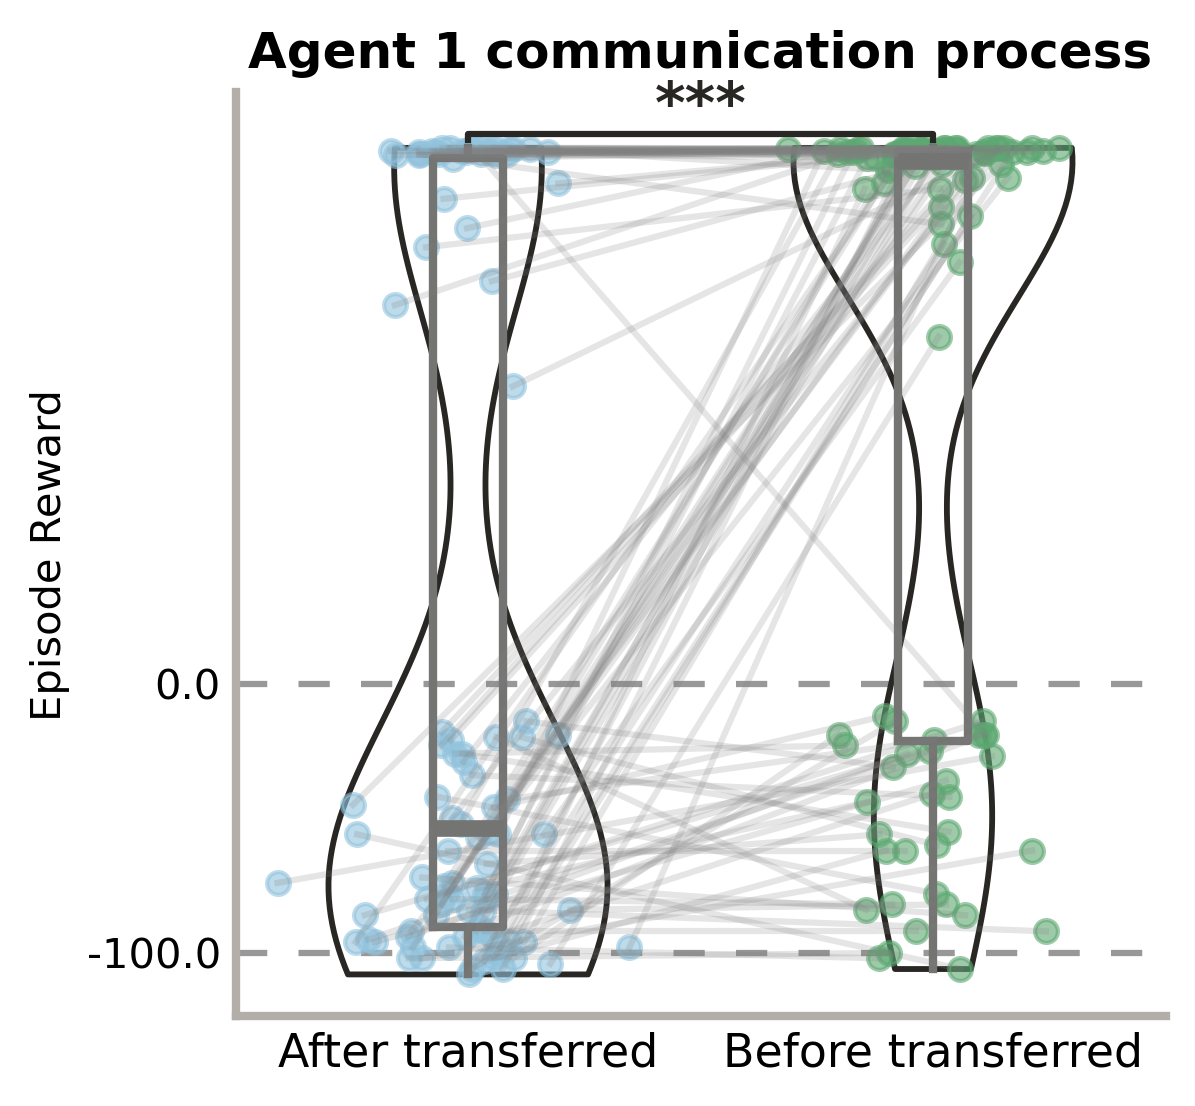

Significance levels legend:
  *** : p < 0.001
  ** : p < 0.01
  * : p < 0.05
  (ns): not significant (p >= 0.05)
--------------------------------------------------
mean 13.90, std 125.43
mean 112.30, std 116.48

--- Paired t-test (difference between samples) ---
Paired test between Sample 1 and Sample 2 (two-sided):
  T-statistic = -7.7074, p-value = 0.0000***
  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 (***).


In [127]:
# load single trail # ------------------
ep_r_before = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_before_test_{unique_str}_trail11.pt")
ep_r_after = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_after_test_{unique_str}_trail11.pt")

# # load average trail # -------------------
# ep_r_before_list = []
# ep_r_after_list = []

# for i in range(10):
#     i_trail = i + 1
#     ep_r_before_i = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_before_test_{unique_str}_trail{i_trail}.pt")
#     ep_r_before_list.append(ep_r_before_i)

#     ep_r_after_i = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_after_test_{unique_str}_trail{i_trail}.pt")
#     ep_r_after_list.append(ep_r_after_i)

# ep_r_before = np.mean(ep_r_before_list, axis=0).tolist()
# ep_r_after = np.mean(ep_r_after_list, axis=0).tolist()

# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [ep_r_before, ep_r_after]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.1
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#92C3DD", "#5DA872"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
# HLINES = [-100.0, 0.0, 100.0, 200]
HLINES = [-100.0, 0.0]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Pairing data points and drawing lines with jitter    
for i in range(len(y_data[0])):
    x1_i = x_jittered[0][i]
    x2_i = x_jittered[1][i]
    ax.plot([x1_i, x2_i], [y_data[0][i], y_data[1][i]], color='gray', alpha=0.2)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)


# Add significance line ----------------------------------------------
# Calculate the height for the significance bar
y_max = max(max(y_data[0]), max(y_data[1]))
bar_height = y_max + 5 # Adjust offset as needed
tick_height = 2       # Height of the small vertical ticks

# Plot the horizontal bar
ax.plot([POSITIONS[0], POSITIONS[0], POSITIONS[1], POSITIONS[1]], 
        [bar_height - tick_height, bar_height, bar_height, bar_height - tick_height], 
        lw=1.5, c=BLACK)

# Add the significance star
ax.text((POSITIONS[0] + POSITIONS[1]) / 2, bar_height + 0.0, "***", ha='center', va='bottom', color=BLACK, fontsize=14, weight="bold")

# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Episode Reward", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["After transferred", "Before transferred"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title(f"Agent {i_agent} communication process", size=12, weight="bold")

plt.show()

# -----------------------------------------------
# Extract the two lists
sample1 = ep_r_before
sample2 = ep_r_after

# --- Helper function to get significance stars ---
def get_significance_stars(p_value):
    """
    Returns significance stars based on p-value.
    ***: p < 0.001
    **:  p < 0.01
    *:   p < 0.05
    """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "" # No stars if not significant at p < 0.05

# --- Print significance legend ---
print("Significance levels legend:")
print("  *** : p < 0.001")
print("  ** : p < 0.01")
print("  * : p < 0.05")
print("  (ns): not significant (p >= 0.05)")
print("-" * 50)

print(f'mean {np.mean(sample1):.2f}, std {np.std(sample1):.2f}')
print(f'mean {np.mean(sample2):.2f}, std {np.std(sample2):.2f}')

print("\n" + "--- Paired t-test (difference between samples) ---")
# --- Test 2: Check if there is a significant difference between the two paired samples ---
# We use a related-samples t-test (paired t-test).
# H0: The true mean difference between paired samples is zero.
# H1: The true mean difference between paired samples is not zero (two-sided test).

t_statistic_paired, p_value_paired = stats.ttest_rel(sample1, sample2, alternative='two-sided') # Default is 'two-sided'
stars_paired = get_significance_stars(p_value_paired)

print(f"Paired test between Sample 1 and Sample 2 (two-sided):")
print(f"  T-statistic = {t_statistic_paired:.4f}, p-value = {p_value_paired:.4f}{stars_paired}")
if p_value_paired < 0.05: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 ({stars_paired if stars_paired else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say there is a significant difference between the means of Sample 1 and Sample 2 (p = {p_value_paired:.4f}, ns).")

# 16. PLOT - Ep_r against random level

/tmp/ipykernel_79945/1514046738.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ep_r_after = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_after_test

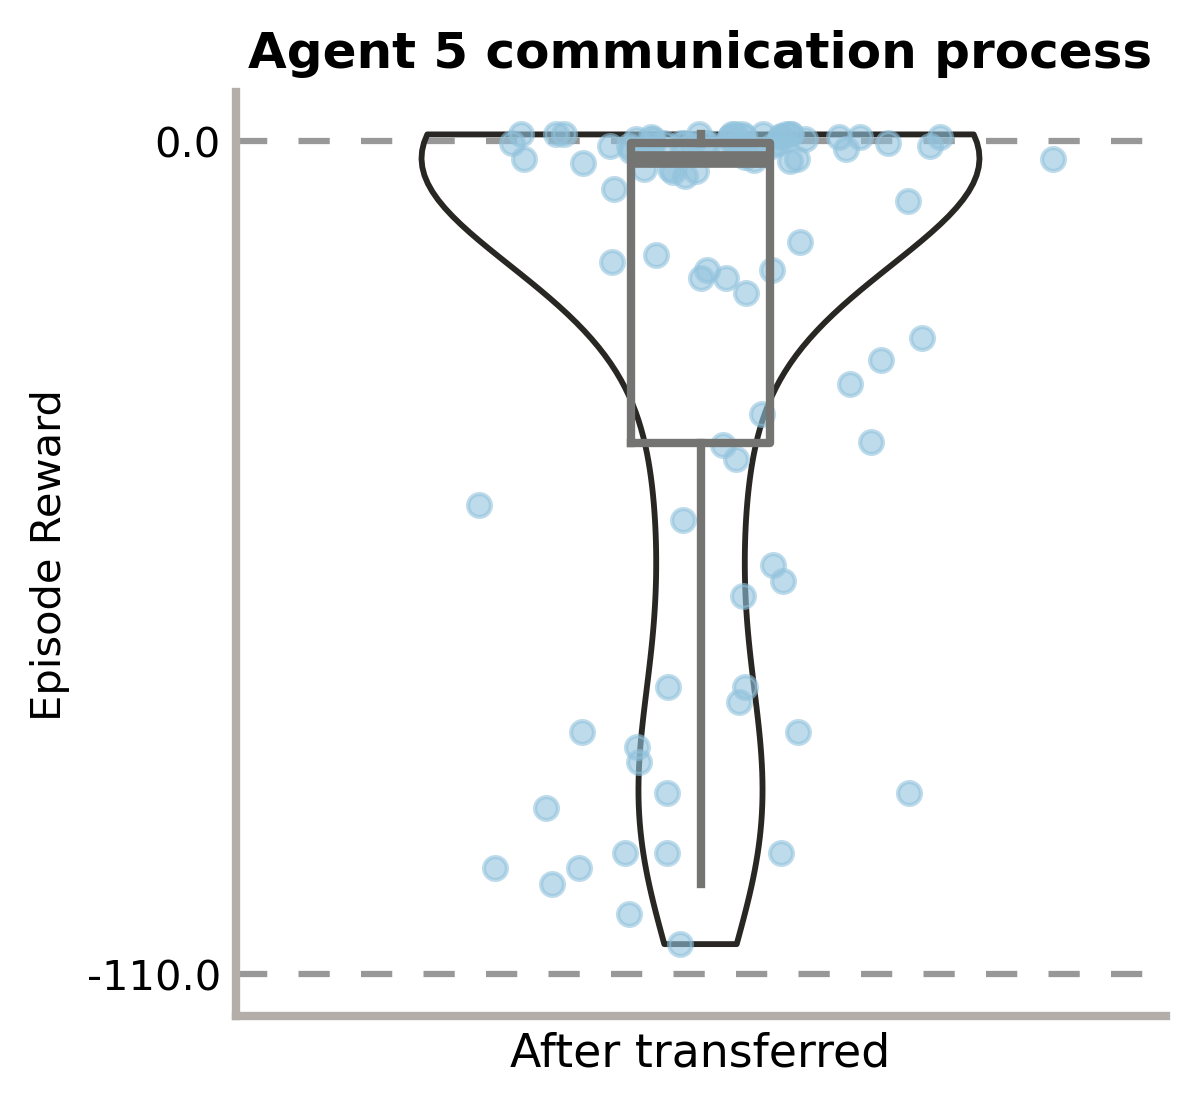

In [10]:
# load single trail # ------------------
ep_r_after = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_after_test_{unique_str}_trail1.pt")

# # load average trail # -------------------
# ep_r_before_list = []
# ep_r_after_list = []

# for i in range(10):
#     i_trail = i + 1
#     ep_r_before_i = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_before_test_{unique_str}_trail{i_trail}.pt")
#     ep_r_before_list.append(ep_r_before_i)

#     ep_r_after_i = torch.load(f"agent_ep_r/{group_str}ep_r{i_agent}of{n_agents}_comm_after_test_{unique_str}_trail{i_trail}.pt")
#     ep_r_after_list.append(ep_r_after_i)

# ep_r_before = np.mean(ep_r_before_list, axis=0).tolist()
# ep_r_after = np.mean(ep_r_after_list, axis=0).tolist()

# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [ep_r_after]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.1
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#92C3DD", "#5DA872"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
# HLINES = [-100.0, 0.0, 100.0, 200]
HLINES = [-110.0, 0.0]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)


# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
y_max = max(y_data[0])
bar_height = y_max + 5
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Episode Reward", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["After transferred"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title(f"Agent {i_agent} communication process", size=12, weight="bold")

plt.show()



# 16. EXECUTION - UMAP visualization of concepts

In [ ]:
path = []
for env_i in env:
    path.append(len(shortest_path(grid_dim, env_i.wall_states, 0, grid_dim**2 - 1)))
# Get the common shortest path
common_shortest_path = np.array(path[0:(n_mazes - n_agents * n_unique)])

# Get the common concept data
concepts = dqn.eval_net.concept_embedding_layer.weight.data.cpu().numpy()
common_concepts = concepts[0:(n_mazes - n_agents * n_unique)]

chosen_indices = random.sample(range(n_mazes - n_agents * n_unique), 2000)
chosen_concepts = common_concepts[chosen_indices]
chosen_shortest_path = common_shortest_path[chosen_indices]

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42) # Added random_state for reproducibility
chosen_concepts_2d = umap_model.fit_transform(chosen_concepts)

# Plot the results with color gradient
plt.figure(figsize=(12, 8)) # Increased figure size slightly for colorbar
scatter = plt.scatter(chosen_concepts_2d[:, 0], chosen_concepts_2d[:, 1], c=chosen_shortest_path, cmap=cm.vik)
plt.colorbar(scatter, label='Shortest Path Length') # Add colorbar
plt.title('UMAP Visualization of Concepts Colored by Shortest Path Length')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
print(torch.tensor(concepts).shape)
# torch.save(torch.tensor(concepts), f'agent_ckpt/{group_str}concepts_of_all.pt')

In [ ]:
path = []
for env_i in env:
    path.append(len(shortest_path(grid_dim, env_i.wall_states, 0, grid_dim**2 - 1)))
# Get the common shortest path
common_shortest_path = np.array(path[0:(n_mazes - n_agents * n_unique)])

# Get the wall01 data
wall_concepts = torch.zeros((n_mazes, grid_dim * grid_dim), dtype=torch.float32)
for i in range(n_mazes):
    wall_concepts[i] = torch.from_numpy(wall_array_dict[i].reshape(1, -1)).float()
common_concepts = wall_concepts[0:(n_mazes - n_agents * n_unique)]

chosen_indices = random.sample(range(n_mazes - n_agents * n_unique), 2000)
chosen_concepts = common_concepts[chosen_indices]
chosen_shortest_path = common_shortest_path[chosen_indices]

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2) # Added random_state for reproducibility
chosen_concepts_2d = umap_model.fit_transform(chosen_concepts)

# Plot the results with color gradient
plt.figure(figsize=(12, 8)) # Increased figure size slightly for colorbar
scatter = plt.scatter(chosen_concepts_2d[:, 0], chosen_concepts_2d[:, 1], c=chosen_shortest_path, cmap=cm.vik)
plt.colorbar(scatter, label='Shortest Path Length') # Add colorbar
plt.title('UMAP Visualization of Concepts Colored by Shortest Path Length')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

# 17. EXECUTION - Policy map

In [ ]:
plot_maze(maze_states2array(wall_state_dict[3740]))

In [ ]:
plot_q_matrix(env, dqn, 3740)

In [ ]:
plot_q_matrix(env, dqn, 3701)

In [ ]:
# Define the colors for the four corners (RGB values)
color1 = np.array([1.0, 1.0, 0.0])  # Yellow (top-right)
color2 = np.array([0.0, 0.0, 1.0])  # Blue (bottom-left)
color3 = np.array([0.0, 1.0, 0.0])  # Green (top-left)
color4 = np.array([1.0, 0.0, 0.0])  # Red (bottom-right)

# Set image resolution and create grid
size = 256
x = np.linspace(0, 1, size)
y = np.linspace(0, 1, size)
X, Y = np.meshgrid(x, y)

# Calculate interpolation weights for each corner
weight_top_left = (1 - X) * (1 - Y)   # Weight for top-left (green)
weight_top_right = X * (1 - Y)        # Weight for top-right (yellow)
weight_bottom_right = X * Y           # Weight for bottom-right (red)
weight_bottom_left = (1 - X) * Y      # Weight for bottom-left (blue)

# Blend colors using the calculated weights
image = (
    color3[:, np.newaxis, np.newaxis] * weight_top_left +  # Green component
    color1[:, np.newaxis, np.newaxis] * weight_top_right + # Yellow component
    color4[:, np.newaxis, np.newaxis] * weight_bottom_right + # Red component
    color2[:, np.newaxis, np.newaxis] * weight_bottom_left    # Blue component
)

# Transpose and reshape to (height, width, RGB)
image = image.transpose(1, 2, 0)

# Create figure and display the image
plt.figure(figsize=(6, 6), dpi=300)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# 18. EXECUTION - Compositionality

## Record Q-matrix

In [ ]:
def get_all_q_values_tensor(dqn, env):
    """
    Calculates the Q(state, action) values for all states and all mazes, storing them in a tensor.

    Args:
        dqn (DQN): The trained DQN agent object. It should have an `eval_net` attribute
                   and be configured with the correct `q_s2a` setting.
        env (list or SquareGridworld): A list of SquareGridworld environments (if n_mazes > 1)
                                       or a single SquareGridworld environment (if n_mazes == 1).
                                       Each environment should have `n_states`, `wall_states`,
                                       and `goal_state` attributes.

    Returns:
        torch.Tensor: A tensor of shape (num_mazes, num_total_states, n_actions) containing
                      the Q-values. `num_mazes` is n_mazes or 1.
                      `num_total_states` is grid_dim * grid_dim.
                      Values for wall states or unreachable states will be 0.
    """
    dqn.eval_net.eval()  # Set the network to evaluation mode

    is_multi_maze = isinstance(env, list)
    num_mazes_to_iterate = n_mazes if is_multi_maze else 1
    num_total_states = grid_dim * grid_dim

    # Initialize the output tensor with zeros on the specified device
    all_q_values_tensor = torch.zeros(
        (num_mazes_to_iterate, num_total_states, n_actions),
        dtype=torch.float32,
        device=device
    )

    with torch.no_grad(): # Disable gradient calculations
        for maze_idx in tqdm(range(num_mazes_to_iterate)):
            current_env = env[maze_idx] if is_multi_maze else env
            wall_states = current_env.wall_states
            goal = current_env.goal_state

            # Prepare maze index tensor
            # Handle case where network expects None if n_mazes == 1 (adjust if needed)
            # Based on Net code, seems to always need index if concepts are used.
            index_tensor = torch.tensor([maze_idx], dtype=torch.int64, device=device)

            for state_int in range(num_total_states):
                # Skip wall states and the goal state (Q-values remain 0)
                if state_int in wall_states or state_int == goal:
                    continue

                state_tensor = state_int_to_tuple(state_int) # Shape: (1, 2)
                if state_tensor is None: # Should not happen for valid state_int
                    continue

                # Calculate Q-values for all actions for the current state
                if q_s2a:
                    # Network outputs Q-values for all actions directly: Q(s) -> [q(s,a0), q(s,a1), ...]
                    q_values_state = dqn.eval_net(state_tensor, index_tensor) # Shape: (1, n_actions)
                else:
                    # Network expects state and action: Q(s, a) -> q
                    # We need to compute Q(s, a) for all 'a'
                    state_tensor_repeated = state_tensor.repeat_interleave(n_actions, dim=0) # Shape: (n_actions, 2)
                    action_tensor = F.one_hot(torch.arange(n_actions, device=device), num_classes=n_actions).float() # Shape: (n_actions, n_actions)
                    state_action_tensor = torch.cat((state_tensor_repeated, action_tensor), dim=1) # Shape: (n_actions, 2 + n_actions)

                    # Repeat index tensor for each action if the network requires it per input instance
                    index_tensor_repeated = index_tensor.repeat(n_actions) # Shape: (n_actions,)

                    # Get Q-value for each state-action pair
                    q_values_state = dqn.eval_net(state_action_tensor, index_tensor_repeated) # Shape: (n_actions, 1)
                    q_values_state = q_values_state.view(1, n_actions) # Reshape to (1, n_actions)

                # Store Q-values in the main tensor
                all_q_values_tensor[maze_idx, state_int, :] = q_values_state.squeeze() # Squeeze removes the dimension of size 1

    # Optional: Set the network back to training mode if needed elsewhere
    # dqn.eval_net.train()

    return all_q_values_tensor

# Example Usage (assuming dqn, env, and global variables are initialized)
# Make sure global variables like n_mazes, grid_dim, n_actions, q_s2a, device are set correctly.

# Example:
# Assuming dqn is an initialized DQN object and env is the environment list/object
all_q_tensor = get_all_q_values_tensor(dqn, env)

# Access Q-values for maze 0, state 5, action 2:
if all_q_tensor is not None:
    q_value = all_q_tensor[0, 5, 2]
    print(f"Q-value for Maze 0, State 5, Action 2: {q_value.item()}") # Use .item() for scalar tensor

    # Get all Q-values for maze 1, state 10
    q_values_m1_s10 = all_q_tensor[1, 10, :]
    print(f"All Q-values for Maze 1, State 10: {q_values_m1_s10}")


In [24]:
if load_ckpt:
    torch.save(all_q_tensor, f'agent_ckpt/{group_str}qmatrix_{i_agent}of{n_agents}.pt')
else:
    torch.save(all_q_tensor, f'agent_ckpt/{group_str}qmatrix_random.pt')

# 19. EXECTUION - Generalization ability test of CA-TS

In [25]:
def gen_new_concept():
    if learn_old_mazes:
        env_test = env[0:n_generalization_mazes]
    else:
        wall_array_dict_test = {}
        i = 0
        while True:
            maze = Maze(n_cell, n_cell)
            maze.generate()
            states_array_tmp = maze.states_array
            if any(np.array_equal(states_array_tmp, states_array_saved) for states_array_saved in wall_array_dict.values()):
                log_print(f"Maze {i} is duplicated", logger)
                continue
            wall_array_dict_test[i] = states_array_tmp
            i += 1
            if i == n_generalization_mazes:
                break

        wall_state_dict_test = {}

        for i in range(n_generalization_mazes):
            wall_state_dict_test[i] = maze_array2states(wall_array_dict_test[i])

        env_test = []
        for i in range(n_generalization_mazes):
            env_test.append(SquareGridworld(goal_state = grid_dim**2 - 1, wall_states = wall_state_dict_test[i]))

    memory_test_counter = 0
    if memory_test_capacity != 0:
        memory_test = np.zeros((memory_test_capacity, 4)) if n_mazes == 1 else np.zeros((memory_test_capacity, 5))
    else:
        memory_test = None

    for maze_test_index in tqdm(range(n_generalization_mazes)):
        current_env = env_test[maze_test_index]
        for state_int in range(current_env.n_states):
            if state_int not in current_env.wall_states:
                next_state_int_0, reward_0 = current_env.get_outcome(state_int, 0)
                next_state_int_1, reward_1 = current_env.get_outcome(state_int, 1)
                next_state_int_2, reward_2 = current_env.get_outcome(state_int, 2)
                next_state_int_3, reward_3 = current_env.get_outcome(state_int, 3)

                memory_test, memory_test_counter = store_transition_offline(
                    memory_test, memory_test_capacity, memory_test_counter, 
                    state_int, 0, reward_0, next_state_int_0, maze_index = maze_test_index + n_mazes, no_repeat = True
                )
                memory_test, memory_test_counter = store_transition_offline(
                    memory_test, memory_test_capacity, memory_test_counter, 
                    state_int, 1, reward_1, next_state_int_1, maze_index = maze_test_index + n_mazes, no_repeat = True
                )
                memory_test, memory_test_counter = store_transition_offline(
                    memory_test, memory_test_capacity, memory_test_counter, 
                    state_int, 2, reward_2, next_state_int_2, maze_index = maze_test_index + n_mazes, no_repeat = True
                )
                memory_test, memory_test_counter = store_transition_offline(
                    memory_test, memory_test_capacity, memory_test_counter, 
                    state_int, 3, reward_3, next_state_int_3, maze_index = maze_test_index + n_mazes, no_repeat = True
                )
    
    if memory_test_capacity == 0: memory_test = np.vstack(memory_test)
    
    # Create new embedding layer with expanded size
    new_embedding = torch.nn.Embedding(n_mazes + n_generalization_mazes, concept_size)
    # Copy existing weights from old embedding layer
    new_embedding.weight.data[:n_mazes,:] = dqn.eval_net.concept_embedding_layer.weight.data.clone()
    # Replace the embedding layer while preserving original weights
    dqn.eval_net.concept_embedding_layer = new_embedding
    dqn.eval_net.to(device)
    dqn.optimizer_concept = torch.optim.Adam(dqn.eval_net.concept_embedding_layer.parameters(), lr = lr_test)
    dqn.memory = memory_test
    dqn.memory_counter = memory_test_counter
    dqn.memory_capacity = memory_test_capacity
    dqn.permuted_indices = None
    dqn.current_idx = 0
    
    # rewrite play in env
    episode_durations = []
    ep_r_durations = []
    path_test = []
    for env_i in env_test:
        path_test.append(shortest_path(grid_dim, env_i.wall_states, 0, grid_dim**2 - 1))
    
    for i_episode in range(n_test_episode):
        if test_rand_start:
            while True:
                start_state_int = random.randint(starting_state, goal_state - 1)
                if start_state_int not in current_env.wall_states:
                    break
        else:
            start_state_int = 0
        
        if i_episode + n_generalization_mazes >= n_test_episode:
            start_state_int = 0
            maze_index = n_generalization_mazes - (n_test_episode - i_episode)
        else:
            maze_index = random.randint(0, len(env_test) - 1)
            
        current_env = env_test[maze_index]
        current_short_path = len(path_test[maze_index]) - 1

        train_dqn_net, train_dqn_concept = False, True

        state_int = start_state_int 
        ep_r = 0
        steps = 0

        while True:
            loss = 0
            done = False
            a = dqn.choose_action(state_int, maze_index + n_mazes, dqn.epsilon)
            next_state_int, reward = current_env.get_outcome(state_int, a)
            ep_r += reward
            steps += 1

            if steps == upper_steps or next_state_int == goal_state: done = True
            
            loss = dqn.learn(train_net = train_dqn_net, train_concept = train_dqn_concept)

            if done:
                episode_durations.append(steps)
                ep_r_durations.append(ep_r)
                log_print(
                    f"Episode: {i_episode}, | "
                    f"Maze index: {maze_index + n_mazes}, |"
                    f"Ep_r: {round(ep_r, 2)}, | "
                    f"loss: {loss:.6f}, | "
                    f"short path: {current_short_path}, | "
                    f"Steps: {steps}, | "
                    f"Memory counter: {dqn.memory_counter} | "
                    f"Start: {state_int_to_tuple(start_state_int).tolist()} | "
                    f"Goal: {state_int_to_tuple(goal_state).tolist()}",
                    logger
                )
                
                break
            
            state_int = next_state_int

if test_concept_generalization:
    gen_new_concept()